### Solar Phase Angle vs. Brightness Plot
This code reads the Pomenis observation database and creates a plot
of AB Magnitude vs. Solar Phase Angle

In [1]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import numpy as np
import lumos.calculator
import lumos.conversions
import satellite_models.starlink_v1p5 as starlink_v1p5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter


In [34]:
# 1) Load data (new path)
# ======================
data_path = r"...\ReFitting\Data_for_Fitting.csv"
data = pd.read_csv(data_path)

# Effective SA column priority: prefer A_eff_SAz, fallback to A_eff_SA
EFF_SA_COL = 'A_eff_SAz' if 'A_eff_SAz' in data.columns else 'A_eff_SA'

# Required columns check
required_cols = ['sun_alt', 'sun_az', 'sat_alt', 'sat_az', 'sat_height', EFF_SA_COL]
missing = [c for c in required_cols if c not in data.columns]
if missing:
    raise ValueError(f"CSV is missing required columns: {missing}")

# Keep only rows where required columns are non-null
data = data.dropna(subset=['sun_alt', 'sun_az', 'sat_alt', 'sat_az', 'sat_height']).copy()

# Keep only nighttime data
night_data = data[data['sun_alt'] < 0].copy()
if night_data.empty:
    raise ValueError("No nighttime data after filtering; please check sun_alt.")

# Phase angle presence check
if 'phase_angle' not in night_data.columns:
    raise ValueError("Column 'phase_angle' is missing; please provide or compute it beforehand.")

# ======================
# 2) Row-wise calculation (effective area & original area)
# ======================
SA_ORIGINAL_AREA = 22.68   # m^2
CHASSIS_ORIGINAL_AREA = 3.64  # m^2

surfaces_template = starlink_v1p5.SURFACES_LAB_BRDFS

eff_mags = []
orig_mags = []

for _, row in night_data.iterrows():
    # --- Altitude unit handling ---
    h_val = float(row['sat_height'])
    height_m = h_val * 1000.0 if h_val < 20000 else h_val  # treat values < 20000 as km, otherwise as meters

    # --- Effective areas ---
    sa_eff = float(row[EFF_SA_COL])


    # chassis: prefer effective column if present; otherwise fallback to original 3.64 m^2
    chassis_eff = float(row['A_eff_chassis']) if 'A_eff_chassis' in night_data.columns and not pd.isna(row.get('A_eff_chassis', np.nan)) else CHASSIS_ORIGINAL_AREA

    eff_surfaces = [
        starlink_v1p5.Surface(chassis_eff, surfaces_template[0].normal, surfaces_template[0].brdf),
        starlink_v1p5.Surface(sa_eff,      surfaces_template[1].normal, surfaces_template[1].brdf)
    ]
    eff_intensity = lumos.calculator.get_intensity_observer_frame(
        eff_surfaces,
        height_m,
        np.array([row['sat_alt']]),
        np.array([row['sat_az']]),
        float(row['sun_alt']),
        float(row['sun_az']),
        include_sun=True,
        include_earthshine=False,
        earth_panel_density=251
    )
    eff_mags.append(lumos.conversions.intensity_to_ab_mag(eff_intensity)[0])

    # --- Original areas ---
    orig_surfaces = [
        starlink_v1p5.Surface(CHASSIS_ORIGINAL_AREA, surfaces_template[0].normal, surfaces_template[0].brdf),
        starlink_v1p5.Surface(SA_ORIGINAL_AREA,      surfaces_template[1].normal, surfaces_template[1].brdf)
    ]
    orig_intensity = lumos.calculator.get_intensity_observer_frame(
        orig_surfaces,
        height_m,
        np.array([row['sat_alt']]),
        np.array([row['sat_az']]),
        float(row['sun_alt']),
        float(row['sun_az']),
        include_sun=True,
        include_earthshine=False,
        earth_panel_density=251
    )
    orig_mags.append(lumos.conversions.intensity_to_ab_mag(orig_intensity)[0])

night_data['mag_eff']  = np.array(eff_mags)
night_data['mag_orig'] = np.array(orig_mags)




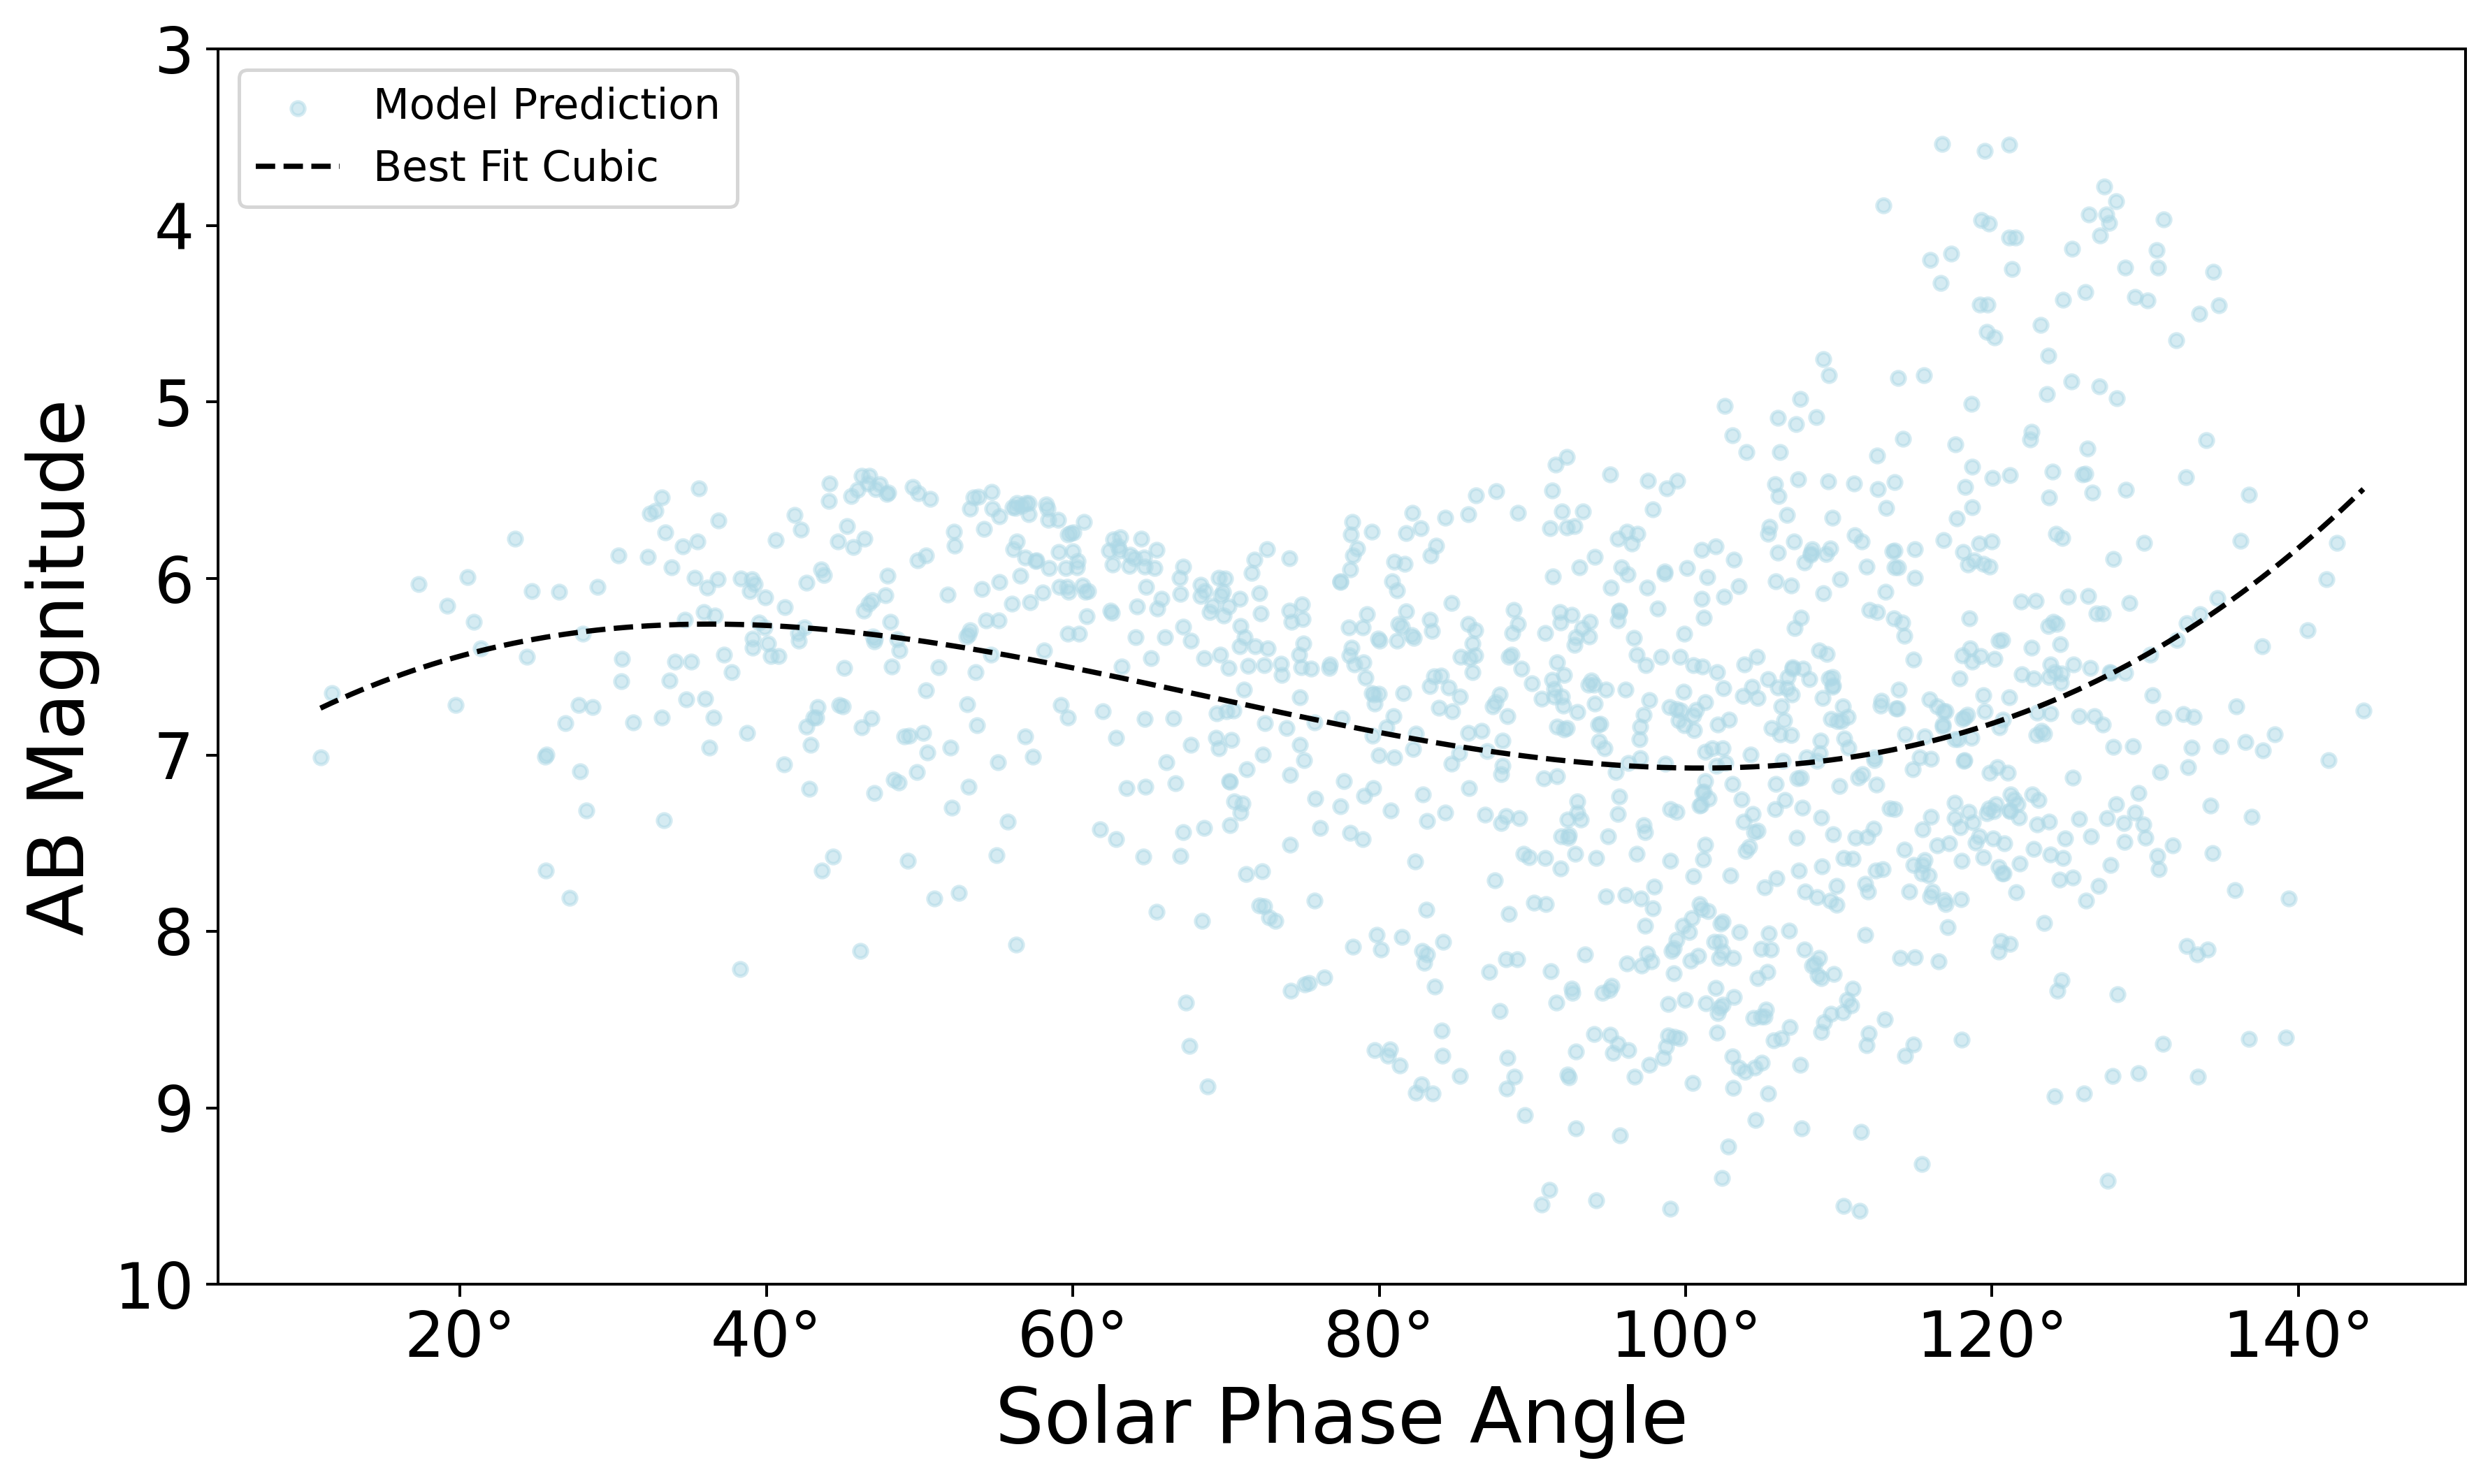

In [35]:
# ======================
# 3) Plotting
# ======================

# ---- Figure ①: Effective area (all data) ----
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=360)
ax.set_ylim(3, 10)
ax.invert_yaxis()
ax.set_xlabel("Solar Phase Angle", fontsize=22)
ax.set_ylabel("AB Magnitude", fontsize=22)
# ax.set_title("Starlink Model (Effective Area, All Night Data)", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))

ax.scatter(night_data['phase_angle'], night_data['mag_eff'],
           alpha=0.5, s=15, label="Model Prediction", color='lightblue')

# Fitting
if len(night_data) >= 4:
    a1, a2, a3, a4 = np.polyfit(night_data['phase_angle'], night_data['mag_eff'], deg=3)
    x = np.linspace(night_data['phase_angle'].min(), night_data['phase_angle'].max(), 400)
    y = a1*x**3 + a2*x**2 + a3*x + a4
    ax.plot(x, y, "--k", label="Best Fit Cubic")

ax.legend(loc=2, prop={'size': 12})
plt.tight_layout()
plt.show()



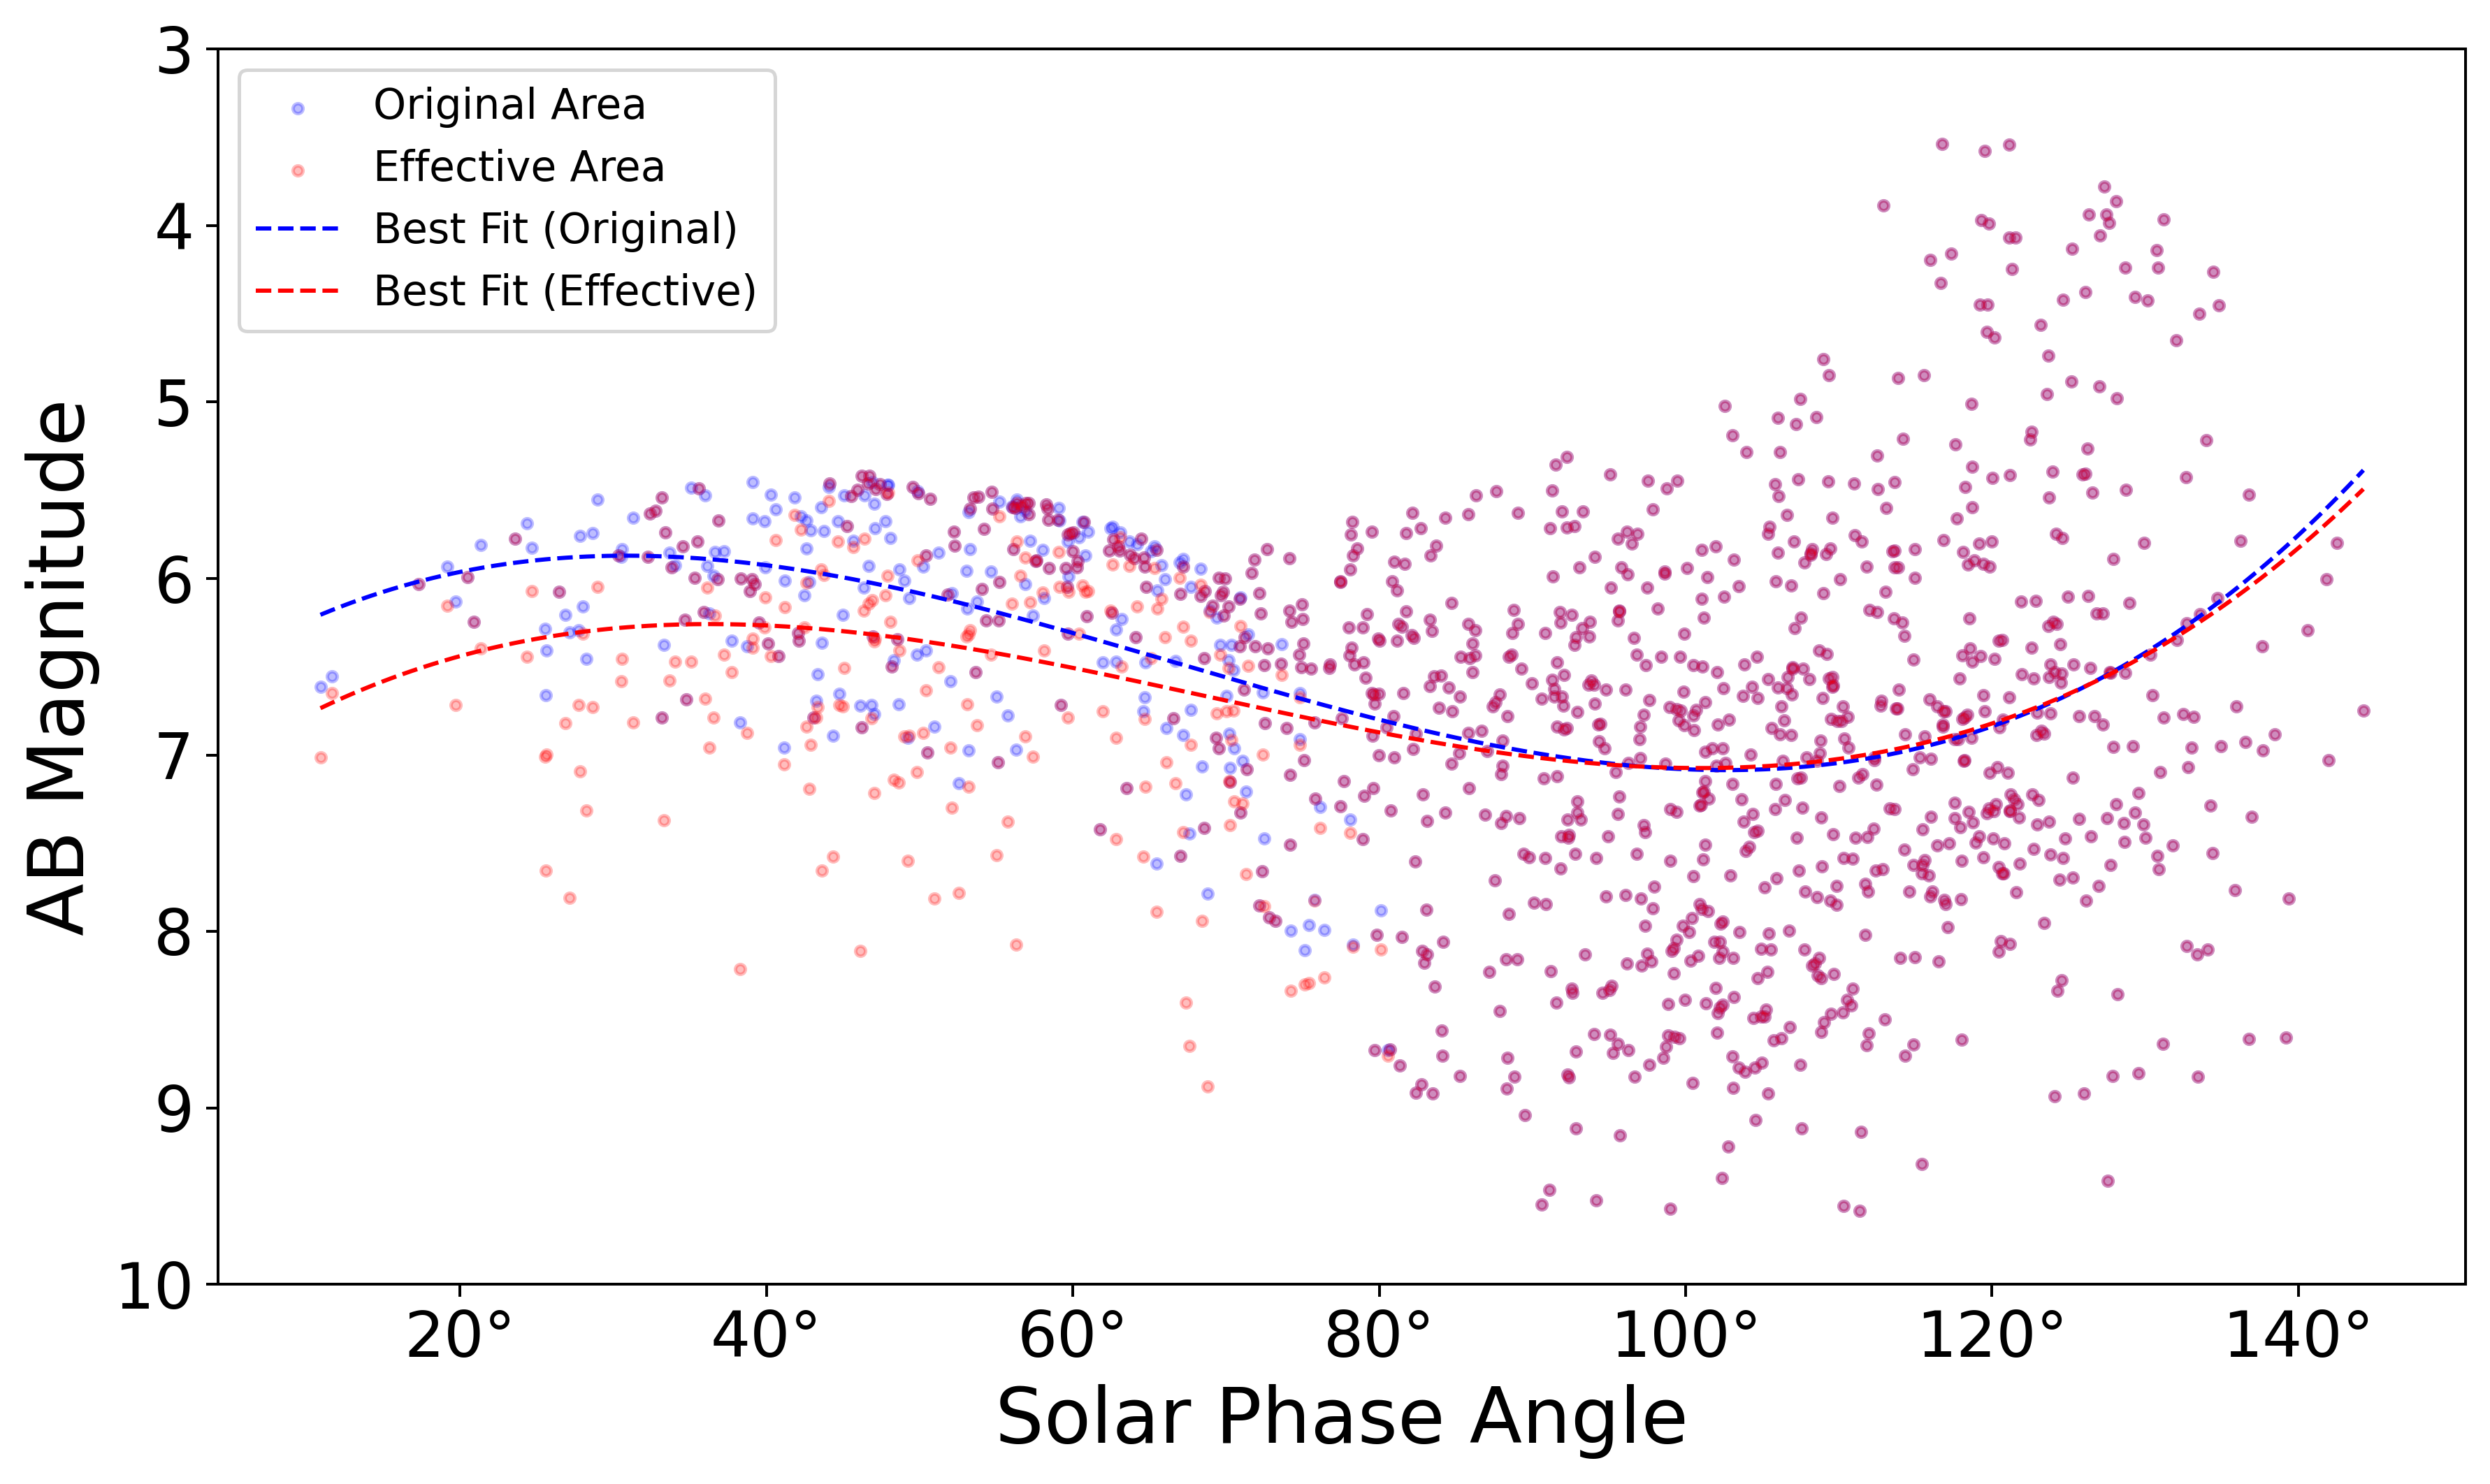

In [36]:
# ---- Figure ②: Effective area vs Original area comparison (all data) ----
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=360)
ax.set_ylim(3, 10)
ax.invert_yaxis()
ax.set_xlabel("Solar Phase Angle", fontsize=22)
ax.set_ylabel("AB Magnitude", fontsize=22)
# ax.set_title("Starlink Model Comparison", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))

ax.scatter(night_data['phase_angle'], night_data['mag_orig'],
           alpha=0.26, s=8, label="Original Area", color='blue')
ax.scatter(night_data['phase_angle'], night_data['mag_eff'],
           alpha=0.26, s=8, label="Effective Area", color='red')

# Individual fits
if len(night_data) >= 4:
    # Fit for original area
    o1, o2, o3, o4 = np.polyfit(night_data['phase_angle'], night_data['mag_orig'], deg=3)
    xx = np.linspace(night_data['phase_angle'].min(), night_data['phase_angle'].max(), 400)
    yy = o1*xx**3 + o2*xx**2 + o3*xx + o4
    ax.plot(xx, yy, "--", linewidth=1.2, label="Best Fit (Original)", color='blue')

    # Fit for effective area
    e1, e2, e3, e4 = np.polyfit(night_data['phase_angle'], night_data['mag_eff'], deg=3)
    yy2 = e1*xx**3 + e2*xx**2 + e3*xx + e4
    ax.plot(xx, yy2, "--", linewidth=1.2, label="Best Fit (Effective)", color='red')

ax.legend(loc=2, prop={'size': 12})
plt.tight_layout()
plt.show()
